In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [2]:
dataset = pd.read_csv('Data/AAPL_stock_data.csv', usecols=['open', 'close', 'high', 'low', 'volume'])
dataStock = dataset.copy()
dataStock = dataStock.dropna()

In [3]:
import sklearn
import sklearn.preprocessing as processing
dataStockNorm = dataStock.copy()
properties = ['open', 'close', 'high', 'low', 'volume']
scalerMinMax = processing.MinMaxScaler()
for i in properties:
    dataStockNorm[i] = scalerMinMax.fit_transform(dataStockNorm[i].values.reshape(-1, 1))

In [4]:
validPercentage = 0.1
testPercentage = 0.1
sequenceLength = 20
dataStockNorm_np = dataStockNorm.to_numpy()
dataSequence = []
for index in range(len(dataStockNorm_np) - sequenceLength):
    dataSequence.append(dataStockNorm_np[index : index+sequenceLength, :])
dataSequence = np.array(dataSequence)
validSize = int(np.round(validPercentage * dataSequence.shape[0]))
testSize = int(np.round(testPercentage * dataSequence.shape[0]))
trainSize = dataSequence.shape[0] - validSize - testSize
print(dataSequence.shape)
xTrain = dataSequence[:trainSize, :-1, :]
yTrain = dataSequence[:trainSize, -1, :]
xValid = dataSequence[trainSize : trainSize+validSize, :-1, :]
yValid = dataSequence[trainSize : trainSize+validSize, -1, :]
xTest = dataSequence[trainSize+validSize:, :-1, :]
yTest = dataSequence[trainSize+validSize:, -1, :]
print(xTrain.shape)
print(yTrain.shape)
print(yValid.shape)
print(xTest.shape)
xTrain = torch.tensor(xTrain, dtype=torch.float32)
yTrain = torch.tensor(yTrain, dtype=torch.float32)
xValid = torch.tensor(xValid, dtype=torch.float32)
yValid = torch.tensor(yValid, dtype=torch.float32)
xTest = torch.tensor(xTest, dtype=torch.float32)
yTest = torch.tensor(yTest, dtype=torch.float32)

(6498, 20, 5)
(5198, 19, 5)
(5198, 5)
(650, 5)
(650, 19, 5)


In [14]:
import NeuralNetworks.lstmStocks as lstmStocks
inputSize = 5
hiddenSize = 256
layers = 2
outputSize = 5
steps = sequenceLength - 1
criterion = nn.MSELoss(reduction='mean')
trainDataset = TensorDataset(xTrain, yTrain)
validDataset = TensorDataset(xValid, yValid)
trainLoader = DataLoader(trainDataset, batch_size=50, shuffle=True, num_workers=2)
validLoader = DataLoader(validDataset, batch_size=1, shuffle=True, num_workers=2)
model = lstmStocks.StockLSTMModel(inputSize, hiddenSize, layers, outputSize, steps)
try:
    model.load_state_dict(torch.load('Model/stock_lstm_model.pth'))
except:
    print('no pretrained model.')
optimizer = lstmStocks.StockLSTMOptimization(model, trainLoader, validLoader, criterion, 'cuda')
optimizer.optimizerAdam(learningRate=0.01)

Epoch [0], Train Loss: 0.001454, Val Loss: 0.251333, 
Epoch [1], Train Loss: 0.000674, Val Loss: 0.364372, 
Epoch [2], Train Loss: 0.000709, Val Loss: 0.244336, 
Epoch [3], Train Loss: 0.000714, Val Loss: 0.188183, 
Epoch [4], Train Loss: 0.000704, Val Loss: 0.697618, 
Epoch [5], Train Loss: 0.000726, Val Loss: 0.798830, 
Epoch [6], Train Loss: 0.000748, Val Loss: 0.548042, 
Epoch [7], Train Loss: 0.000705, Val Loss: 0.231686, 
Epoch [8], Train Loss: 0.000736, Val Loss: 0.149064, 
Epoch [9], Train Loss: 0.000749, Val Loss: 0.180050, 
Epoch [10], Train Loss: 0.000725, Val Loss: 0.308524, 
Epoch [11], Train Loss: 0.000724, Val Loss: 0.197560, 
Epoch [12], Train Loss: 0.000828, Val Loss: 0.316056, 
Epoch [13], Train Loss: 0.000741, Val Loss: 0.130115, 
Epoch [14], Train Loss: 0.000726, Val Loss: 0.049071, 
Epoch [15], Train Loss: 0.000728, Val Loss: 0.101800, 
Epoch [16], Train Loss: 0.000676, Val Loss: 0.120151, 
Epoch [17], Train Loss: 0.000753, Val Loss: 0.108658, 
Epoch [18], Train Lo

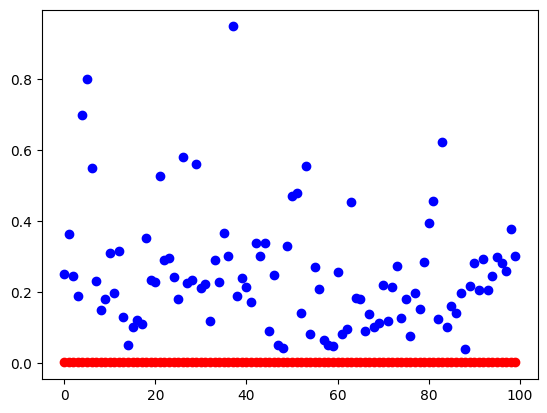

In [15]:
for i in range(100):
    train_loss = optimizer.trainEpoch()
    valid_loss = optimizer.validEpoch()
    print(f'Epoch [{i}], '
        f'Train Loss: {train_loss:.6f}, '
        f'Val Loss: {valid_loss:.6f}, ')
    plt.scatter(i, train_loss, c='r')
    plt.scatter(i, valid_loss, c='b')

In [7]:
model_cpu = model.to('cpu')
prediction = model_cpu(xTest)
print(prediction.shape)

torch.Size([650, 5])


We can see that the generated results from trainned model basically match Test set with a constant bias.

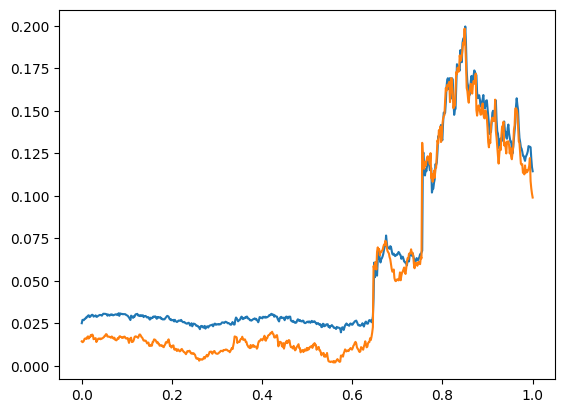

In [8]:
prediction_np = prediction.detach().numpy()
plt.plot(np.linspace(0, 1, prediction_np.shape[0]), prediction_np[:, 2])
plt.plot(np.linspace(0, 1, prediction_np.shape[0]), yTest[:, 2])

torch.Size([650, 5])


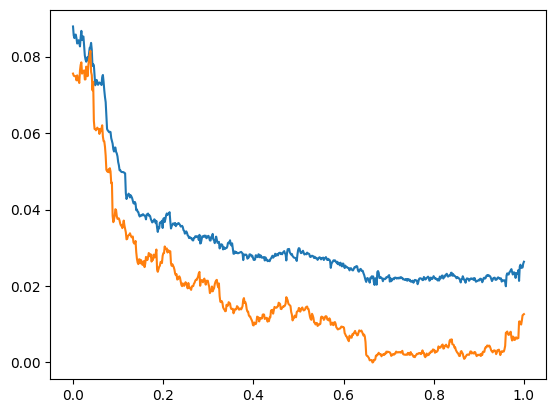

In [16]:
torch.save(model_cpu.state_dict(), 'Model/stock_lstm_model_1.pth')
loaded_model = lstmStocks.StockLSTMModel(inputSize, hiddenSize, layers, outputSize, steps)
loaded_model.load_state_dict(torch.load('Model/stock_lstm_model_1.pth'))
loaded_model.eval()
prediction = model_cpu(xValid)
print(prediction.shape)
prediction_np = prediction.detach().numpy()
plt.plot(np.linspace(0, 1, prediction_np.shape[0]), prediction_np[:, 2])
plt.plot(np.linspace(0, 1, prediction_np.shape[0]), yValid[:, 2])